<a href="https://colab.research.google.com/github/cagbaraji/COMP5013-Improvement-of-SRGAN/blob/main/COMP5013_CW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from torch.utils.tensorboard import SummaryWriter

Define transformations

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std
])

Load CITAR-100 Dataset

100%|██████████| 169001437/169001437 [00:04<00:00, 41595459.24it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([64, 3, 32, 32])
torch.Size([64])
labels: tensor([41, 38, 46, 39, 31, 62, 73, 33, 55, 40, 53, 55, 56, 54,  5, 91,  9, 50,
        89, 37, 20, 25, 33, 75, 59, 66, 96,  2, 50, 98, 90, 54, 32,  6, 69, 79,
        99, 57, 77, 74, 86, 24, 51, 81, 72, 57, 40, 90, 31, 93, 50, 93, 33, 83,
        58, 81, 44, 10, 38, 67, 35, 69, 51, 22])


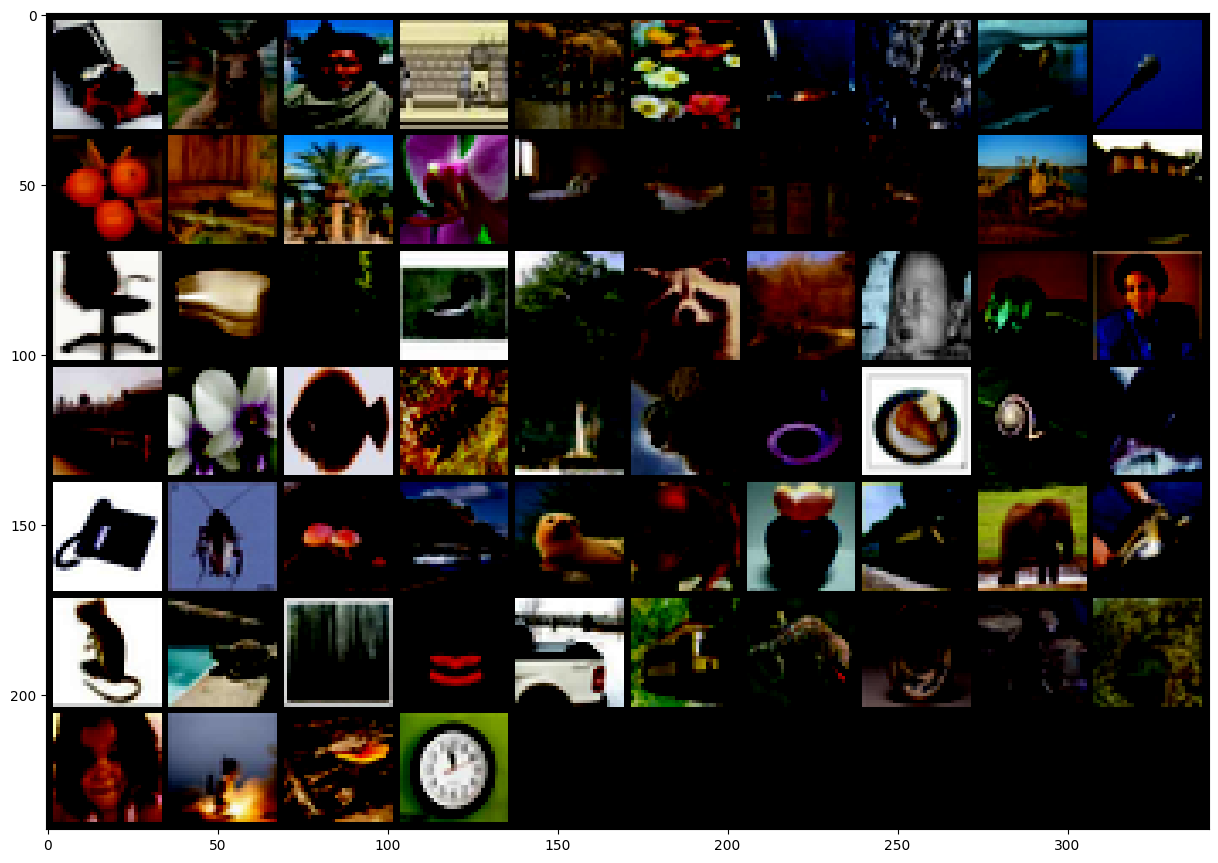

In [3]:
train_set = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Load CIFAR-100 test dataset
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

batch = next(iter(train_loader))

images, labels = batch

print(images.shape)
print(labels.shape)
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))

print('labels:', labels)

Neural Network and PyTorch design

In [4]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.out = nn.Linear(in_features=84, out_features=10)

  def forward(self, t):
    #Layer 1
    t = t
    #Layer 2
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)#output shape : (6,14,14)
    #Layer 3
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)#output shape : (16,5,5)
    #Layer 4
    t = t.reshape(-1, 16*5*5)
    t = self.fc1(t)
    t = F.relu(t)#output shape : (1,120)
    #Layer 5
    t = self.fc2(t)
    t = F.relu(t)#output shape : (1, 84)
    #Layer 6/ Output Layer
    t = self.out(t)#output shape : (1,10)

    return t

network = Network()

# Training the Neural Network
Defining a Loss Function and a Optimizer

In [7]:
# Define your neural network
class YourNetwork(nn.Module):
    def __init__(self):
        super(YourNetwork, self).__init__()
        # Define your network architecture here
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 100)  # CIFAR-100 has 100 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 8 * 8)  # Flatten the output for fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of your network
network = YourNetwork()

# Define the optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# Assuming you've already defined and initialized train_loader and test_loader for CIFAR-100 dataset

# Training loop
for epoch in range(20):
    total_correct = 0
    total_loss = 0
    for batch in train_loader:
        images, labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += preds.argmax(dim=1).eq(labels).sum().item()

    print('epoch:', epoch, "total_correct:", total_correct, "loss:", total_loss)

print('>>> Training Complete >>>')


epoch: 0 total_correct: 9216 loss: 2682.3206288814545
epoch: 1 total_correct: 16809 loss: 2049.968227982521
epoch: 2 total_correct: 21070 loss: 1737.745745897293
epoch: 3 total_correct: 24593 loss: 1484.9196392297745
epoch: 4 total_correct: 28206 loss: 1242.7572085857391
epoch: 5 total_correct: 31850 loss: 1016.7871850728989
epoch: 6 total_correct: 35317 loss: 797.7722725272179
epoch: 7 total_correct: 38700 loss: 602.5232181549072
epoch: 8 total_correct: 41460 loss: 443.91981913149357
epoch: 9 total_correct: 43788 loss: 319.8036698848009
epoch: 10 total_correct: 45174 loss: 243.765339307487
epoch: 11 total_correct: 46167 loss: 191.03414007276297
epoch: 12 total_correct: 46594 loss: 166.68706464394927
epoch: 13 total_correct: 46855 loss: 153.69834416732192
epoch: 14 total_correct: 47148 loss: 139.27383655309677
epoch: 15 total_correct: 47509 loss: 119.80478669330478
epoch: 16 total_correct: 47606 loss: 118.01311022974551
epoch: 17 total_correct: 47462 loss: 122.75003760214895
epoch: 18 

# Predictions
Defining a function to get all predictions at once.
Loading the Saved Model.


In [8]:
# Perform predictions on the test set
network.eval()
test_preds = []
actual_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        preds = network(images)
        test_preds.extend(preds.argmax(dim=1).tolist())
        actual_labels.extend(labels.tolist())

# Calculate total correct predictions and accuracy
preds_correct = np.sum(np.array(test_preds) == np.array(actual_labels))
accuracy = preds_correct / len(actual_labels)
print('total correct:', preds_correct)
print('accuracy:', accuracy)

total correct: 3620
accuracy: 0.362


# Plotting the Confusiopn Matrix

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(test_set.targets, test_preds.argmax(dim=1))
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']
plt.figure(figsize=(100,100))
plot_confusion_matrix(cm, classes)

AttributeError: 'list' object has no attribute 'argmax'